## This notebook contains:
## 1. Sentiment model training with combined dataset from NYT data, Kaggle Tweet Sentiment, and Financial News Sentiment
## 2. Export of trained model in TF SavedModel format
## 3. Export of trained tokenizer in .pickle format
## 4. Loading tokenizer and model for prediction

by Theo

# Model training

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt

In [3]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/news_data')

In [4]:
import pandas as pd

data = pd.read_csv('combined_data.csv')

In [5]:
data["Sentiment"].value_counts()

POSITIVE    801451
NEGATIVE    800656
NEUTRAL       5582
Name: Sentiment, dtype: int64

In [6]:
X = data['Body']
y = data['Sentiment']

In [7]:
y = pd.get_dummies(y)

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 100000, oov_token='<oov>')
tokenizer.fit_on_texts(X)

In [9]:
from keras.preprocessing.sequence import pad_sequences

X_preprocessed = tokenizer.texts_to_sequences(X)
maxlen = 512
X_preprocessed = pad_sequences(X_preprocessed, maxlen=maxlen, padding='pre', truncating='pre')
X_preprocessed

array([[    0,     0,     0, ...,  1029,  9816,     3],
       [    0,     0,     0, ...,  1280,    11,   489],
       [    0,     0,     0, ...,   315,   755,  4146],
       ...,
       [    0,     0,     0, ...,    15,    12,  2068],
       [    0,     0,     0, ..., 14752,     1,     1],
       [    0,     0,     0, ...,     1,     1,     1]], dtype=int32)

Stratified split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(X_preprocessed, y, stratify=y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.5)

In [13]:
print(X_train.shape)
print(y_train.shape)

(1286151, 512)
(1286151, 3)


In [16]:
num_outputs = y_train.shape[1]
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 100

tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=maxlen),
                                 keras.layers.Bidirectional(keras.layers.GRU(64)),
                                 keras.layers.Dense(num_outputs, activation='softmax')])

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [22]:
history = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/2
10049/10049 [==============================] - 713s 71ms/step - loss: 0.4070 - accuracy: 0.8152 - auc: 0.9485 - val_loss: 0.3827 - val_accuracy: 0.8279 - val_auc: 0.9546
Epoch 2/2
10049/10049 [==============================] - 714s 71ms/step - loss: 0.3432 - accuracy: 0.8495 - auc: 0.9638 - val_loss: 0.3797 - val_accuracy: 0.8299 - val_auc: 0.9554


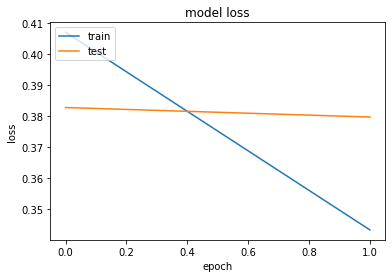

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

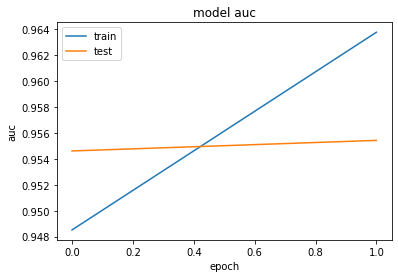

In [25]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(np.argmax(np.array(y_test), axis=-1), y_pred, target_names=['NEGATIVE', 'NEUTRAL', 'POSITIVE']))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.87      0.84     80066
     NEUTRAL       0.82      0.85      0.84       558
    POSITIVE       0.86      0.79      0.82     80145

    accuracy                           0.83    160769
   macro avg       0.83      0.84      0.83    160769
weighted avg       0.83      0.83      0.83    160769



# Export tokenizer

In [27]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Export SavedModel

In [30]:
model.save('sentiment_model_v2')

INFO:tensorflow:Assets written to: sentiment_model_v2/assets


INFO:tensorflow:Assets written to: sentiment_model_v2/assets


# Load tokenizer and model for prediction

Load tokenizer

In [48]:
with open('tokenizer.pickle', 'rb') as handle:
  loaded_tokenizer = pickle.load(handle)

Load SavedModel

In [49]:
loaded_model = keras.models.load_model('sentiment_model_v2')

Sample text

In [61]:
sample_text = 'This has been the worst trade deal in the history of trade deals, maybe ever'

Preprocess using tf.keras.tokenizer and tf.keras.pad_sequences

maxlen = 512 was used to train model

In [62]:
sample_text = loaded_tokenizer.texts_to_sequences([sample_text])
sample_text = pad_sequences(sample_text, maxlen=512, padding='pre', truncating='pre')

In [73]:
sample_prediction = np.argmax(loaded_model.predict(sample_text), axis=-1)[0]
sample_predicted_class = ['NEGATIVE', 'NEUTRAL', 'POSITIVE'][sample_prediction]
sample_prediction_score = np.max(loaded_model.predict(sample_text))

In [80]:
print(f'argmax prediction: {sample_prediction}')
print(f'predicted class: {sample_predicted_class}')
print(f'prediction score: {sample_prediction_score}')

argmax prediction: 0
predicted class: NEGATIVE
prediction score: 0.720095694065094
